## Motywacja

Sieci neuronowe działają, ponieważ efektywnie aproksymują pewne rozkłady prawdopodobieństwa. Celem tych ćwiczeń jest zrozumienie, co konkretnie jest aproksymowane (chwilowo nie interesuje nas, w jaki sposób).
Wiedza ta jest potrzebna, aby dobrze zaplanować architekturę modelu i poprawnie wybrać funkcję kosztu.

## Modele generatywne

Zadaniem modeli generatywnych jest generowanie danych podobnych (pochodzących z tego samego rozkładu) do tych, które były obserwowane podczas uczenia.

Do tej pory omawialiśmy modele dyskryminatywne - one z kolei uczą się "opisywać" dane, np. przypisując im klasę, do jakiej należą.

Przykładowy efekt działania modelu generatywnego - zdjęcia sypialni

<img src="figures/L2/gan2.png">

Przykładowy efekt niedziałania modelu generatywnego - zdjęcia psów (chyba)

<img src="figures/L2/gan.png">


## Model generatywny rzutu monetą.

Spróbujmy wytrenować model generatywny pewnej (być może niesymetrycznej) monety.

Obserwacje to wyniki kolejnych rzutów monetą. Na ich podstawie model estymuje rozkład prawdopodobieństwa, z jakiego one pochodzą, czyli po prostu prawdopodobieństwo wylosowania orła - oznaczmy je literą $\theta$. Uczenie modelu to estymowanie tego parametru.

Następnie model może **generować** wyniki kolejnych rzutów. W tym wypadku jest to bardzo proste, wystarczy np. użyć generatora liczb losowych, który z prawdopodobieństwem $\theta$ wypisze ORZEŁ, a z prawdopodobieństwem $1-\theta$ będzie to RESZKA.

Jeśli na przykład prawdziwe $\theta$ wynosi $70\%$, a wyestymowane $60\%$, to zauważymy, że generowane dane nie są podobne do danych prawdziwych - ORZEŁ będzie pojawiał się zbyt rzadko. Jest to analogia do powyższych zdjęć psów. Poprawnie wytrenowany model będzie średnio generował tyle samo ORŁÓW, co prawdziwa moneta i w tym sensie dane pochodzące z modelu będą dla nas nieodróżnialne od danych prawdziwych (analogia do zdjęć sypialnii).

W powyższym przykładzie estymowany rozkład jest dyskretny (dwie możliwości: ORZEŁ i RESZKA), natomiast parametr $\theta$ teoretycznie może przyjmować dowolną wartość z przedziału $[0,1]$ (a więc jest ciągły).

Z uwagi na architekturę komputerów w praktyce wszystkie rozkłady i parametry zawsze będą dyskretne, liczba możliwych wartości $\theta$ będzie zależeć przede wszystkim od precyzji użytych floatów.

Rozpatrywanie wszystkich możliwych wartości parametrów jest oczywiście zbyt czasochłonne. Stosuje się więc przybliżenia, a w tym celu łatwiej myśleć o parametrach jako wielkościach ciągłych i korzystać z twierdzeń analizy matematycznej. Podobna uwaga dotyczy rozkładów prawdopodobieństwa - dla przykładu, jeśli chcemy wylosować obrazek, to myślimy o pikselach jako punktach pochodzących z ciągłej trójwymiarowej kostki (kolor).

## Podejście maximum likelihood

Załóżmy, że w $10$ rzutach monetą otrzymaliśmy $7$ orłów i $3$ reszki (rzuty są od siebie niezależne, więc istotna jest tylko sumaryczna liczba orłów i reszek, a nie kolejność wyników).

Zdefiniujmy funkcję likelihood:
$$L(\theta|\mathrm{obserwacje}) := P(\mathrm{obserwacje}|\theta)$$

Chcemy tak dobrać $\theta$, aby zmaksymalizować $L$ - innymi słowy wybieramy taką wartość $\theta$, przy której mielibyśmy największe szanse na uzyskanie wyników, które zaobserwowaliśmy.

$$L(\theta|\mathrm{obserwacje}) = P(\mathrm{siedem~orłów~i~trzy~reszki}|\theta) = \theta^7 (1-\theta)^3$$

Okazuje się, że w wypadku prób Bernoulliego (rzutów niesymetryczną monetą) $L$ jest maksymalizowane przez:
$$\theta = \frac{\mathrm{liczba~sukcesów}}{\mathrm{liczba~prób}}$$
Innymi słowy, jeśli w $10$ rzutach wypadło $7$ orłów, to szacujemy prawdopodobieństwo wyrzucenia orła na $\frac{7}{10}$.

## Ćwiczenie 1 (0,5 pkt)

Narysować wykres funkcji $L(\theta)$ dla $\theta\in[0,1]$. Zobaczyć, że maksimum jest w punkcie $\frac{7}{10}$.

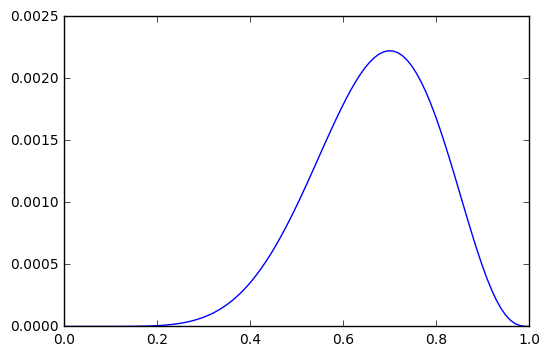

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def L(theta):
    return (theta**7)*(1-theta)**3

theta_grid = np.linspace(0,1,100)
L_values = [L(a) for a in theta_grid]

plt.plot(theta_grid, L_values)
plt.show()

## Ćwiczenie 2 (0,5 pkt)

Symulator "prawdziwej" monety.

Napisać funkcję flip_coin, która generuje wynik nb_flips rzutów monetą z prawdopodobieństwem wypadnięcia orła równym theta. Funkcja ma zwrócić tablicę zer i jedynek ($0$ - RESZKA, $1$ - ORZEŁ).


In [14]:
def flip_coin(theta, nb_flips):
    probs = [theta, 1-theta]
    items = [1,0]
    result = [np.random.choice(items, p=probs) for x in range(nb_flips)]
    assert len(result) == nb_flips
    return result
print flip_coin(0.7, 10)

[1, 0, 0, 1, 0, 0, 0, 1, 1, 0]


## Ćwiczenie 3 (1 pkt)

Pierwszy model generatywny rzutu monetą.

Napisać klasę CoinML (Maximum Likelihood) posiadającą metody fit i toss:
- fit - przyjmuje listę obserwacji i oblicza self.theta korzystając z wzoru powyżej.
- toss - generuje jeden rzut monetą z prawdopodobieństwem self.theta i zwraca 0 lub 1.

In [31]:
class CoinML(object):

    def __init__(self):
        self.theta = None

    def fit(self, X):
        self.theta = sum(X)/float(len(X))

    def toss(self):
        return np.random.choice([1,0], p=[self.theta, 1-self.theta])
        
coin = CoinML()
data = [np.random.choice([1,0], p=[0.7, 0.3]) for x in range(100)]
coin.fit(data)
print sum([coin.toss() for x in range(100)])/100.0

0.55


## Wzór Bayesa

Załóżmy teraz, że w "fabryce monet" produkowane są tylko monety symetryczne ($\theta = 0.5$) oraz monety z wadą ($\theta = 0.6$).

W 10 rzutach monetą otrzymaliśmy 7 orłów i 3 reszki. Jak teraz wybrać właściwe $\theta$?

Można np. porównać $L(0.5) < L(0.6)$ i zdecydować się na $\theta=0.6$.

Załóżmy inaczej - wiemy, że średnio co piąta moneta produkowana jest z wadą. Czy wtedy też wybierzemy $\theta=0.6$? A jeśli tylko jedna na tysiąc jest wadliwa? Jak bardzo nieprawdopodobne musi być to, że nasza moneta jest wadliwa, abyśmy przestali wierzyć funkcji likelihood?

https://xkcd.com/1132/

https://www.explainxkcd.com/wiki/index.php/1132:_Frequentists_vs._Bayesians

<img src="figures/L2/frequentists_vs_bayesians.png">

## Prawdopodobieństwo warunkowe - przypomnienie

https://www.youtube.com/watch?v=H02B3aMNKzE

<img src="figures/L2/cond_prob.jpg">

## Wzór Bayesa

A - parametry rozkładu.
B - obserwacja.

$$P(A\mid B) = \frac{P(B\mid A)\,P(A)}{P(B)}$$

Wersja rozszerzona, używana np. wtedy (w praktyce zawsze), gdy nie znamy prawdopodobieństwa B, ale znamy je z osobna dla każdego zestawu parametrów A.

$$P(B) = {\sum_j P(B\mid A_j) P(A_j)}$$
$$P(A_i\mid B) = \frac{P(B\mid A_i)\,P(A_i)}{\sum\limits_j P(B\mid A_j)\,P(A_j)}$$

Prawdopodobieństwa $P(A_i)$ po prawej stronie wzoru nazywamy wiedzą a priori, $P(A_i\mid B)$ po lewej wiedzą a posteriori. Gdy pojawią się nowe obserwacje, wiedza a posteriori staje się znowu wiedzą a priori i stosujemy wzór Bayesa kolejny raz ($P(A_i\mid B_{\mathrm{stare}})$ podstawiamy pod $P(A_i)$ i liczymy $P(A_i\mid B_{\mathrm{nowe}})$). Niezależnie od obserwacji $P(B\mid A_i)$ nie ulega zmianie (dlaczego?).

Wróćmy do przykładu, w którym średnio co piąta moneta jest wadliwa. Niech $A_1$ oznacza $\theta = 0.5$, a $A_2$ oznacza $\theta = 0.6$. B to nasze obserwacje - siedem orłów i trzy reszki. Wtedy:
- $P(A_1) = \frac45$,
- $P(A_2) = \frac15$,
- $P(B\mid A_1) = (\frac12)^7(\frac12)^3 = \frac{1}{1024}$,
- $P(B\mid A_2) = (\frac{6}{10})^7(\frac{4}{10})^3 = \frac{17496}{9765625}$,
- $P(A_1\mid B) = \frac{ \frac45 \frac{1}{1024} }{ \frac45 \frac{1}{1024} + \frac15 \frac{17496}{9765625} } \approx 0.686$
- $P(A_2\mid B) = \frac{ \frac15 \frac{17496}{9765625} }{ \frac45 \frac{1}{1024} + \frac15 \frac{17496}{9765625} } \approx 0.314$

Czyli wciąż jest około dwa razy większa szansa, że rzucamy symetryczną monetą!

#### Uwaga 1.
Obserwacje można podać w dowolnej kolejności, można podawać je po jednej i stosować wzór wielokrotnie, można po kilka, można wszystkie jednocześnie, a wynik będzie ten sam...

#### Uwaga 2.
...teoretycznie, bo w praktyce jeśli obserwacji jest dużo, to mamy szansę uzyskać błędny wynik ze względu na numeryczną niestabilność.

# Najważniejsza rzecz do zrozumienia - robimy rozkład prawdopodobieństwa na rozkładach prawdopodobieństwa!

<img src="figures/L2/dawg_bayes.jpg">

Nasza moneta jest opisana rozkładem prawdopodobieństwa na dwóch możliwych zdarzeniach elementarnych (wynikach rzutu) {ORZEŁ, RESZKA}:
- $P(\mathrm{ORZEŁ}) = \theta$,
- $P(\mathrm{RESZKA}) = 1 - \theta$.

Na tych rozkładach robimy drugi rozkład prawdopodobieństwa:
- $\mathcal{P}(\theta=0.5) = \frac45$,
- $\mathcal{P}(\theta=0.6) = \frac15$.

Rozkłady $P$ **nie ulegają zmianie**. Jest to rodzina wszystkich możliwych rozkładów, które bierzemy pod uwagę (w tym wypadku mamy dwa rozkłady dla dwóch różnych $\theta$; zawsze zakładamy, że dokładnie jeden z nich jest "prawdziwy").

Rozkład $\mathcal{P}$ **ulega zmianie** po każdej nowej obserwacji.

## Dwa sposoby interpretowania prawdopodobieństwa

1. Jako cecha pewnego obiektu ($P$ jest "wbudowaną" własnością monety).

2. Jako stan naszej wiedzy o świecie ($\mathcal{P}$ nie jest cechą żadnej istniejącej rzeczy, dlatego może ulegać zmianom).

Jeśli interpretujemy $\mathcal{P}$ jako wiedzę, to nie powinna nas dziwić Uwaga 1.

Przy dużej liczbie obserwacji cała gęstość rozkładu $\mathcal{P}$ zaczyna koncentrować się bardzo blisko wokół prawdziwego $P$.

Zazwyczaj jeśli rozkład $P$ zależy od parametrów - w tym wypadku $\theta$ - to te parametry piszemy w indeksie dolnym. Jeśli rozpatrujemy wszystkie możliwe $\theta$, to napisalibyśmy, że $\{P_\theta\}_{\theta\in[0,1]}$ jest sparametryzowaną rodziną rozkładów prawdopodobieństwa.

W bardziej skomplikowanych problemach nie da się sensownie sparametryzować kilkoma liczbami wszystkich możliwych rozkładów prawdopodobieństwa, ale mimo to czasem staramy się to zrobić. Dzięki temu można próbować udowadniać twierdzenia, które zakładają uproszczony obraz świata, a następnie stosować je jako heurystyki.

Z punktu widzenia wzoru Bayesa rodzina rozpatrywanych rozkładów prawdopodobieństwa nie musi być wcale sparametryzowana - jeśli mamy zbiór takich rozkładów, to możemy je po prostu ponumerować i piszemy wtedy np. $\mathcal{P}(P_1) = 0.7, \mathcal{P}(P_2) = 0.1, \mathcal{P}(P_3) = 0.15, \ldots$

#### Uwaga 3.

Jeśli przyjmiemy, że pewien rozkład $P$ ma a priori $\mathcal{P}$ równe zero, to $\mathcal{P}$ a posteriori też będzie równe zero, niezależnie od siły dowodów przemawiających za tym konkretnym $P$. Dlatego nie należy wykluczać a priori żadnego $P$, jeśli nie jesteśmy całkowicie pewni, że jest ono niemożliwe.

Przy braku wiedzy a priori trzeba tak dobrać $\mathcal{P}$, aby wszędzie było niezerowe (np. jeśli bierzemy pod uwagę $n$ różnych rozkładów $P$, to $\mathcal{P}$ jest równe stale $\frac1n$; jeśli rozkłady są sparametryzowane odcinkiem $[a,b]$, to $\mathcal{P}$ jest rozkładem jednostajnym na tym odcinku; jeśli rozkłady są sparametryzowane całą prostą rzeczywistą, to $\mathcal{P}$ oczywiście nie może być rozkładem jednostajnym, wtedy używamy np. rozkładu Gaussa o średniej zero i wariancji jeden; itd.).

#### Uwaga 4.

W wypadku rzutu monetą mamy tylko dwa możliwe zdarzenia elementarne, więc wszystkie rozkłady można sparametryzować odcinkiem $[0,1]$.

Dla kostki sześciennej jest podobnie - jest sześć zdarzeń elementarnych, więc wszystkie rozkłady można sparametryzować szóstkami nieujemnych liczb rzeczywistych, które sumują się do jedności (5-wymiarowy sympleks w $\mathbb{R}^6$).

W obu powyższych przypadkach zdarzeń elementarnych jest skończenie wiele, a możliwych rozkładów continuum.

Ale co się dzieje, gdy zdarzeń elementarnych jest nieskończenie wiele? Można np. powiedzieć, że przestrzeń kolorów jest ciągła i wtedy wszystkich możliwych obrazków jest nieskończenie wiele (continuum). Da się udowodnić, że możliwych rozkładów prawdopodobieństwa $P$ wciąż jest continuum, ale ciężko nadać im jakąkolwiek strukturę i zdefiniować $\mathcal{P}$ jako rozkład jednostajny na niej.

## Podejście maximum a posteriori

Zasada postępowania jest prosta:
1. Mamy dany pewien rozkład a priori oraz obserwacje.
2. Korzystając ze wzoru Bayesa obliczamy rozkład a posteriori.
3. Wybieramy ten rozkład $P$, którego prawdopodobieństwo a posteriori jest największe.

## Ćwiczenie 4 (1 pkt)

Napisać klasę CoinMAP (Maximum A Posteriori) posiadającą metody fit i toss:
- konstruktor - przyjmuje prior, który może np. być słownikiem (klucz - $\theta$, wartość - jej prawdopodobieństwo a priori),
- fit - przyjmuje listę obserwacji i uaktualnia self.knowledge, korzystając ze wzoru Bayesa, a następnie ustawia self.theta wybierając odpowiednią wartość z self.knowledge,
- toss - generuje jeden rzut monetą z prawdopodobieństwem self.theta i zwraca 0 lub 1.

In [1]:
import numpy as np

class CoinMAP(object):

    def __init__(self, prior):
        self.knowledge = prior
        self.theta = 0
    def compute(self,i,j,X):
        return j*((i**sum(X))*(1-i)**(len(X)-sum(X)))
    
    def fit(self, X):
        m = 0
        for i,j in self.knowledge.iteritems():
            v = self.compute(i,j,X)
            s = sum([self.compute(i1,j1,X) 
                     for i1,j1 in self.knowledge.iteritems()])
            v /= s
            if m < v:
                self.theta = i

    def toss(self):
        return np.random.choice([1,0], p=[self.theta, 1-self.theta])

model = CoinMAP({0.5: 0.8, 0.6: 0.2})
model.fit(np.array([1,0,1,1,1,0,0,1,1,1]))
print "model.knowledge powinno wyjść {0.5: 0.686, 0.6: 0.314}"
print model.knowledge
print "Powinno wyjść 0.5:", model.theta
print "Powinno wyjść 1:", sum(model.knowledge.values())

model = CoinMAP({0.5: 0.5, 0.6: 0.2, 0.8: 0.3})
model.fit(np.array([1,0,1,1,1,0,0,1,1,1]))
print "model.knowledge powinno wyjść {0.5: 0.362, 0.6: 0.265, 0.8: 0.373}"
print model.knowledge
print "Powinno wyjść 0.8:", model.theta
print "Powinno wyjść 1:", sum(model.knowledge.values())

model.knowledge powinno wyjść {0.5: 0.686, 0.6: 0.314}
{0.5: 0.8, 0.6: 0.2}
Powinno wyjść 0.5: 0.6
Powinno wyjść 1: 1.0
model.knowledge powinno wyjść {0.5: 0.362, 0.6: 0.265, 0.8: 0.373}
{0.5: 0.5, 0.6: 0.2, 0.8: 0.3}
Powinno wyjść 0.8: 0.8
Powinno wyjść 1: 1.0


## Jedyne Słuszne Podejście - całka po rozkładzie a posteriori

Dotychczas korzystaliśmy tylko z części wiedzy na temat rozkładów - dlaczego nie użyć jej całej?

Jeśli wiemy, że z prawdopodobieństwem 0.686 prawdopodobieństwo wypadnięcia orła wynosi 0.5, a z prawdopodobieństwem 0.314 prawdopodobieństwo wypadnięcia orła wynosi 0.6, to jakie jest ostateczne prawdopodobieństwo wypadnięcia orła?

$$P(\mathrm{ORZEŁ}) = \mathcal{P}(\theta = 0.5)P(\mathrm{ORZEŁ} \mid \theta = 0.5) + \mathcal{P}(\theta = 0.6)P(\mathrm{ORZEŁ} \mid \theta = 0.6) = 0.686 * 0.5 + 0.314 * 0.6 \approx 0.531 $$

W wersji z większą liczbą możliwych wartości $\theta$:
$$P(\mathrm{ORZEŁ}) = \sum_{\theta_j} \mathcal{P}(\theta = \theta_j)P(\mathrm{ORZEŁ} \mid \theta = \theta_j) = \sum_{\theta_j} \mathcal{P}(\theta = \theta_j)\theta_j $$

#### Uwaga 5.

Opisane tu podejście jest jedynym poprawnym sposobem uczenia się rozkładu danych na podstawie obserwacji. Nie będzie niespodzianką fakt, że w praktyce jest ono niewykonalne...

## Ćwiczenie 5 (2 pkt)

Napisać klasę CoinBest, która działa jak CoinMAP z tą różnicą, że self.theta jest obliczane powyższym wzorem, a nie wybierane spośród wartości self.knowledge.

In [53]:
class CoinBest(object):

    def __init__(self, prior):
        self.knowledge = prior
        self.theta = None
        
    def compute(self,i,j,X):
        return j*((i**sum(X))*((1-i)**(len(X)-sum(X))))
    
    def fit(self, X):
        self.theta = 0
        for i,j in self.knowledge.iteritems():
            v = self.compute(i,j,X)
            s = sum([self.compute(i1,j1,X) 
                     for i1,j1 in self.knowledge.iteritems()])
            v /= s
            v *= i
            self.theta += v

    def toss(self):
        return np.random.choice([1,0], p=[self.theta, 1-self.theta])

model = CoinBest({0.5: 0.8, 0.6: 0.2})
model.fit(np.array([1,0,1,1,1,0,0,1,1,1]))
print "model.knowledge powinno wyjść {0.5: 0.686, 0.6: 0.314}"
print model.knowledge
print "Powinno wyjść około 0.53:", model.theta
print "Powinno wyjść 1:", sum(model.knowledge.values())

model = CoinBest({0.5: 0.5, 0.6: 0.2, 0.8: 0.3})
model.fit(np.array([1,0,1,1,1,0,0,1,1,1]))
print "model.knowledge powinno wyjść {0.5: 0.362, 0.6: 0.265, 0.8: 0.373}"
print model.knowledge
print "Powinno wyjść około 0.64:", model.theta
print "Powinno wyjść 1:", sum(model.knowledge.values())

0.531443323685
Powinno wyjść 1: 1.0
0.638398817627
Powinno wyjść 1: 1.0


## Porównanie powyższych metod

Wybiegnijmy trochę do przodu:
- ML jest najgorsze, ale najprostsze,
- ML z sensowną regularyzacją ma przybliżać MAP,
- MAP przy dużej liczbie obserwacji przybliża całkę po rozkładzie a posteriori.


## Metoda Monte Carlo
(tak naprawdę metody, bo jest ich wiele, ale wszystkie opierają się na jednym prostym pomyśle)

Przykład:

Załóżmy, że opracowaliśmy nową strategię gry w Blackjacka, która zakłada m.in. zliczanie schodzących kart. Zanim zaczniemy stosować ją w kasynie chcemy upewnić się, że faktycznie jest ona skuteczna, to znaczy średnia wygrana jest większa od zera (albo średnia wygrana na godzinę gry jest większa od płacy minimalnej).

Krupier gra deterministycznie, więc przebieg gry zależy tylko i wyłącznie od kolejności kart w talii. Niestety, takich ułożeń jest bardzo dużo, a ponadto zasady Blackjacka przewidują kilka specjalnych sytuacji, przez co bardzo ciężko (jeśli jest to w ogóle możliwe) zapisać wzór na średnią wygraną. Co zrobić w takiej sytuacji?

Rozwiązanie:

Skoro krupier jest deterministyczny, to rozgrywamy bardzo dużo (im więcej, tym lepiej) gier z symulowanym krupierem i uśredniamy wygrane.

Monte Carlo!

#### Uwaga 6.

Jeśli tylko da się nie używać Monte Carlo, to należy nie używać Monte Carlo. Ale zazwyczaj się nie da.

## Paradoks Monty'ego Halla

Przeliczmy jeszcze raz przykład z wykładu, korzystając ze wzoru Bayesa.

Przypomnienie:

Mamy trzy bramki, za jedną z nich znajduje się nagroda, za pozostałymi dwiema koza. Gracz wybiera jedną z trzech bramek. Prowadzący grę, który zna położenie nagrody, odsłania jedną z pozostałych dwóch bramek, przy czym zawsze w odsłoniętej bramce znajduje się koza. Gracz ma teraz możliwość zmiany bramki.

Wersja z piorunem: po wybraniu bramki piorun trafia losowo w jedną z pozostałych dwóch i odsłania jej zawartość. Gracz ma możliwość zmiany bramki na drugą zasłoniętą.

Zastanówmy się chwilę, jak zdefiniować $P$ i $\mathcal{P}$. Interesującą nas wielkością jest prawdopodobieństwo wygranej po wybraniu pewnej ustalonej bramki. Załóżmy na chwilę, że nagroda znajduje się w pierwszej bramce. Wtedy prawdopodobieństwo wygranej przy wybraniu pierwszej bramki wynosi 100%, natomiast w wypadku drugiej i trzeciej jest to oczywiście 0%. Mówienie w tym miejscu o prawdopodobieństwach może wydawać się sztuczne, ale jest to konieczne, aby móc zastosować wzór Bayesa. Możemy myśleć o trzech bramkach jako o trzech monetach, z których dokładnie jedna ma $\theta = 1$, a pozostałe dwie $0$.

Jeśli trzy bramki zwracają nagrody z prawdopodobieństwami odpowiednio $\theta_1$, $\theta_2$ i $\theta_3$, to zapiszemy taką sytuację jako:
$$P \sim (\theta_1, \theta_2, \theta_3)$$

W takim razie mamy dokładnie trzy możliwości:
- $P_1 \sim (1,0,0)$,
- $P_2 \sim (0,1,0)$,
- $P_3 \sim (0,0,1)$.

Każda z nich jest a priori jednakowo prawdopodobna, możemy więc zapisać:
- $\mathcal{P}(P_1) = \frac13$,
- $\mathcal{P}(P_2) = \frac13$,
- $\mathcal{P}(P_3) = \frac13$.

Załóżmy teraz, że gracz wybrał na początku bramkę nr 1. Prowadzący odsłonił bramkę nr 2 i była tam koza. Jak zmieniła się wartość $\mathcal{P}$? Zauważmy, że:
- $P(\mathrm{obserwacja}\mid P_1) = \frac12$ - ponieważ jeśli nagroda jest w pierwszej bramce, to prowadzący losowo odsłania bramkę nr 2 lub nr 3,
- $P(\mathrm{obserwacja}\mid P_2) = 0$ - nagroda nie może być w bramce z kozą,
- $P(\mathrm{obserwacja}\mid P_3) = 1$ - prowadzący musi odsłonić bramkę nr 2.

Podstawiając do wzoru Bayesa (proszę przeliczyć to przynajmniej raz na kartce) otrzymamy ostatecznie:
- $\mathcal{P}(P_1\mid\mathrm{obserwacja}) = \frac13$,
- $\mathcal{P}(P_2\mid\mathrm{obserwacja}) = 0$,
- $\mathcal{P}(P_3\mid\mathrm{obserwacja}) = \frac23$

na końcu dla każdej bramki liczymy prawdopodobieństwo wylosowania nagrody po wyborze tejże bramki - oczywiście w tym celu liczymy całkę po rozkładzie a posteriori i otrzymujemy prawdopodobieństwa: $\frac13 * 1 + 0 * 0 + \frac23 * 0 = \frac13, \frac13 * 0 + 0 * 1 + \frac23 * 0 = 0, \frac13 * 0 + 0 * 0 + \frac23 * 1 = \frac23$. Dlatego opłaca się zmienić bramkę na trzecią.

Wersja z piorunem: gracz wybrał na początku bramkę nr 1. Piorun uderzył w bramkę nr 2 i była tam koza. Jak zmieniła się wartość $\mathcal{P}$? Zauważmy, że:
- $P(\mathrm{obserwacja}\mid P_1) = \frac12$ - piorun uderza losowo,
- $P(\mathrm{obserwacja}\mid P_2) = 0$ - nagroda nie może być w bramce z kozą,
- $P(\mathrm{obserwacja}\mid P_3) = \frac12$ - piorun uderza losowo.

Podstawiając do wzoru Bayesa (proszę przeliczyć to przynajmniej drugi raz na kartce) otrzymamy ostatecznie:
- $\mathcal{P}(P_1\mid\mathrm{obserwacja}) = \frac12$,
- $\mathcal{P}(P_2\mid\mathrm{obserwacja}) = 0$,
- $\mathcal{P}(P_3\mid\mathrm{obserwacja}) = \frac12$

a po policzeniu całek po rozkładzie a posteriori otrzymamy prawdopodobieństwa $\frac12, 0, \frac12$ i dlatego nie ma znaczenia, czy zmienimy bramkę na trzecią.

Pytanie kontrolne - dlaczego musimy liczyć całki po rozkładzie a posteriori, skoro wynik wychodzi taki sam, jak rozkład a posteriori?

## Ćwiczenie 6 (1 pkt)

Zasymulować metodą Monte Carlo przebieg rozgrywki dla gracza, który:
- nie zmienia bramki,
- zawsze zmienia bramkę,

w przypadku:
- zwykłym,
- z piorunem, a jeśli trafi w nagrodę to:
	- powtórka,
	- przegrana.

Wypisać średnią wygraną.

In [128]:
def _open(possible, win):
    if win in possible:
        return [x for x in possible if win != x][0]
    else:
        return np.random.choice(possible)

def monte_carlo(change, lghtg, repeat):
    results = []
    for i in range(3000):
        possible = [0,1,2]
        win = np.random.choice(possible)#losujemy wygrana bramke
        choice = np.random.choice(possible)#losujemy wybor
        possible.remove(choice)#usuwamy wybor
        if lghtg:
            destroyed = np.random.choice(possible) #losujemy zesputa
            if destroyed == win: 
                if repeat:
                    continue
                else:
                    results.append(False)
                    continue
            else:
                possible.remove(destroyed)
        else:
            opened = _open(possible, win)
            possible.remove(opened)
        if change:
            choice = possible[0]
        results.append(win == choice)
    return sum([1 for x in results if x])/float(len(results))

config = [['Change', 'Lightning', 'repeat'],
         [0,0,0],[0,1,1],[0,1,0],[1,0,0],[1,1,1],[1,1,0]]

print '%s %s %s' % tuple(config[0])
for con in config[1:]:
    
    print '%s      %s         %s     %s' % tuple(con +[round(monte_carlo(*con), 2)])

# spodziewany wynik:
#  - bez zmiany bramki:
#     - zwykły: 1/3
#     - piorun z powtórką: 1/2
#     - piorun z przegraną: 1/3
#  - ze zmianą bramki:
#     - zwykły: 2/3
#     - piorun z powtórką: 1/2
#     - piorun z przegraną: 1/3

Change Lightning repeat
0      0         0     0.33
0      1         1     0.5
0      1         0     0.32
1      0         0     0.66
1      1         1     0.51
1      1         0     0.33


## Ćwiczenie 7 (1 pkt)

Losujemy $k=100$ razy liczbę od $1$ do $m=200$ z rozkładem jednostajnym. Ile średnio różnych liczb wylosujemy?
Rozwiązać metodą Monte Carlo.

https://math.dartmouth.edu/archive/m19w03/public_html/Section6-5.pdf - czy wynik zgadza się z tw. 6.14?


In [141]:
def f(k, m, nb_simulations):
    m = range(m) # od 0 do 199 ale to bez znaczenia w eksperymencie
    result = []
    for _ in range(nb_simulations):
        res = []
        for _ in range(k):
            res.append(np.random.choice(m))
        result.append(len(set(res)))
    avg_nb_integers = np.mean(result)
    return avg_nb_integers

k = 100
m = 200
print f(k, m, nb_simulations=1000), "=?=", m - (k * (1 - 1/float(k))**m)
#NIE

78.879 =?= 186.602032514


## Rozkład Gaussa - przypomnienie

Spróbujmy zaprzyjaźnić się z n-wymiarowym rozkładem Gaussa.

wzór na gęstość rozkładu gaussa:

$$f(x \; | \; \mu, \sigma^2) = \frac{1}{\sqrt{2\sigma^2\pi} } \; e^{ -\frac{(x-\mu)^2}{2\sigma^2} }$$

wersja n-wymiarowa:
https://en.wikipedia.org/wiki/Multivariate_normal_distribution

Macierz kowariancji rozkładu n-wymiarowego musi być dodatnio określona.

## Ćwiczenie 8 (2 pkt)

Napisać funkcję, która przyjmuje parametry rozkładu normalnego: średnią oraz macierz kowariancji, liczbę sampli, a następnie sampluje punkty z tego rozkładu i rysuje na plaszczyźnie. Ponadto na rysunku należy zaznaczyć strzałkami wektory własne macierzy kowariancji (punkt zaczepienia to średnia rozkładu normalnego) i wypisać odpowiadające im wartości własne.

Narysować powyższe dla kilku różnych losowo wybranych średnich i macierzy kowariancji (http://stackoverflow.com/questions/619335/a-simple-algorithm-for-generating-positive-semidefinite-matrices).


[ 1.  1.]


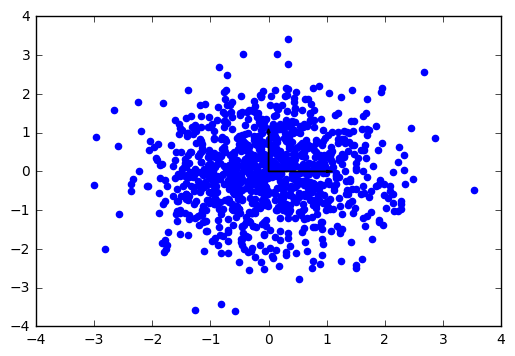

In [166]:
import matplotlib.pyplot as plt
import numpy as np
mean = [0,0]
cov = np.array([[1,0],[0,1]])
def plot(mean, cov):
    samples = np.random.multivariate_normal(mean, cov, size=1000)
#     print samples
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    print eigenvalues
    
    w, v = np.linalg.eig(cov)
    plt.scatter(samples[:,0], samples[:,1], color='b')
    plt.arrow(mean[0], mean[1], eigenvectors[0][0], eigenvectors[0][1], head_width=0.05, head_length=0.1, fc='k', ec='k')
    plt.arrow(mean[0], mean[1], eigenvectors[1][0], eigenvectors[1][1], head_width=0.05, head_length=0.1, fc='k', ec='k')

    plt.show()

plot(mean, cov)
# wynik: spodziewamy się elipsy o środku w średniej rozkładu,
# tam też powinna być największa gęstość samplowanych punktów;
# wektory własne powinny wskazywać kierunki osi elipsy;
# jaki jest związek wartości własnych z długościami osi elipsy?

## Ćwiczenie 9 (4 pkt)

Załóżmy, że mamy dane pochodzące dwuwymiarowego rozkładu normalnego o macierzy kowariancji będącej identycznością i średniej $\mu$. Będziemy estymowali $\mu$ korzystając z wzoru Bayesa.

1. Stworzyć siatkę 100x100 na kwadracie $[0,1]^2$ - to będą nasze potencjalne średnie.
2. Wylosować jeden punkt z siatki - to będzie "prawdziwa" średnia rozkładu. Oczywiście model jej nie zna.
3. Przyjąć jednostajny rozkład a priori (użyć floatów z największą możliwą precyzją), trzymać go w tablicy knowledge.
4. Powtórzyć nb_iters razy:
    - wygenerować nb_samples sampli z prawdziwego rozkładu,
    - uaktualnić knowledge na podstawie obserwacji,
    - narysować knowledge jako dwuwymiarowy heatmap.

Sprawdzić, co się stanie, gdy:
1. Siatka punktów będzie rzadsza, a prawdziwa średnia rozkładu będzie poza siatką.
2. Średnia rozkładu znajdzie się całkowicie poza badanym kwadratem, np. w punkcie $(1.2, 0.7)$.
3. Na początku wylosujemy 2 punkty z siatki - $\mu_1$ i $\mu_2$ - a następnie obserwacje będziemy samplować naprzemian z dwóch rozkładów gaussa, przy czym cały czas estymujemy $\mu$ tak, jak gdyby istniało dokładnie jedno prawdziwe.